# Data Mining iMessage Chats

*January 2021*

## Introduction

This project aims to explore the messaging habits between me and my friend Leah. Model classifying the sender based on message contents incoming soon...

## Dataset Creation and Cleaning

### Creation

Apple hosts an SQL database of iMessage chats located in ~/Library/Messages/chat.db. Using TablePlus, I accessed the database and created a CSV file with information on all the messages sent in one chat.

The database gives each chat a unique chat id. In order to find the id of the desired chat whose data I wanted to download, I used a unique message sent in the chat to search.

In [ ]:
SELECT
    message.text,
    chat.chat_identifier
FROM
    chat
    JOIN chat_message_join ON chat. "ROWID" = chat_message_join.chat_id
    JOIN message ON chat_message_join.message_id = message. "ROWID"
WHERE
    message.text like 'What if we get cancele'
ORDER BY
    message_date ASC;

After determining that the chat id was 30, I was able to export a CSV file containing information on the ROWID, text, is_from_me, and date of every message sent in the chat.

In [ ]:
SELECT
    ROWID,
    text,
    is_from_me,
    datetime(date/1000000000 + strftime("%s", "2001-01-01") ,"unixepoch","localtime")  as date
FROM
    message T1
    INNER JOIN chat_message_join T2 ON T2.chat_id = 30
        AND T1.ROWID = T2.message_id
    ORDER BY
        T1.date;

### Cleaning

In [3]:
import sqlite3
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#plt.style.use('fivethirtyeight')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('seaborn-poster')

import seaborn as sns
sns.set(style='ticks', font_scale=1.2)
import numpy as np

import re

import nltk
from nltk.corpus import stopwords

from collections import Counter

In [31]:
df = pd.read_csv('/Users/indiachina/Desktop/Data Science/Chat Leah/leahChat.db.csv')
df=df.rename(columns={"date_utc": "date"})
df.head()

,ROWID,text,is_from_me,date
0,4842,Lmao,0,2019-08-19 07:06:03
1,4843,I had a weird dream,0,2019-08-19 07:54:10
2,4844,I'm going to Boston by train today right,0,2019-08-19 07:54:17
3,4845,But I dreamt that my dad was like you're takin...,0,2019-08-19 07:54:29
4,4846,And then I was confused when I woke up,0,2019-08-19 07:54:37


Using the is_from_me column, I'm adding a column attributing the message to the sender

In [32]:
# adding column with sender name
df['sender'] = 0
df.loc[df['is_from_me'] == 0, 'sender'] = 'leah'
df.loc[df['is_from_me'] == 1, 'sender'] = 'cindy'
df = df.drop(['ROWID'], axis=1)
df.head()

,text,is_from_me,date,sender
0,Lmao,0,2019-08-19 07:06:03,leah
1,I had a weird dream,0,2019-08-19 07:54:10,leah
2,I'm going to Boston by train today right,0,2019-08-19 07:54:17,leah
3,But I dreamt that my dad was like you're takin...,0,2019-08-19 07:54:29,leah
4,And then I was confused when I woke up,0,2019-08-19 07:54:37,leah


I also decided to add two columns for the number of words and the number of characters in the message.

In [33]:
# num words
df['word_ct'] = df['text'].apply(lambda x: len(str(x).split(" ")))

# num chars
df['character_ct'] = df['text'].str.len()
df['character_ct'] = df['character_ct'].astype('float')

Next, I created a new column titled "text_edited" that made all of the contents in the text column lowercase and got rid of the punctuation marks.

In [34]:
# converting the column objects to correct types
df['date'] = pd.to_datetime(df['date'])
df['text'] = df['text'].astype('str')

In [35]:
def remove_punctuation_and_replace_numbers(text):
    
    text = re.sub(r'[^\sA-Za-z0-9]', ' ', text)
    return text

In [36]:
#lowercase
df['text_edited'] = df['text'].str.lower().apply(remove_punctuation_and_replace_numbers)
df['text_edited'] = df.text_edited.apply(lambda x: re.sub(" +" , " ", x))
df.iloc[15].text_edited 
df.tail()

,text,is_from_me,date,sender,word_ct,character_ct,text_edited
37062,I’ll send u a report,1,2022-01-09 22:13:58,cindy,5,20.0,i ll send u a report
37063,Ims cared,0,2022-01-09 22:14:02,leah,3,10.0,ims cared
37064,HAHAHA,1,2022-01-09 22:14:04,cindy,1,6.0,hahaha
37065,What if we get cancele,0,2022-01-09 22:14:06,leah,5,22.0,what if we get cancele
37066,No dont be,1,2022-01-09 22:14:09,cindy,3,10.0,no dont be


## Exploratory Data Analysis

In [37]:
print(len(df))
df.word_ct.sum()

37067


212741

Between August 19, 2019 and January 9th, 2022, 212,741 words across 37,067 messages have been sent in the chat, with a breakdown of the message contributions below:

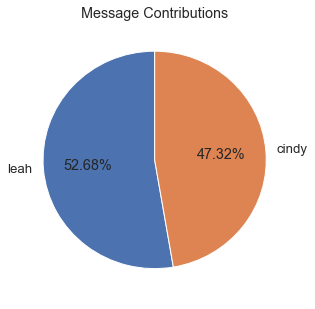

leah     19528
cindy    17539
Name: sender, dtype: int64


In [38]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.pie(df.sender.value_counts(), labels=df.sender.value_counts().index, startangle=90, 
       autopct='%1.2f%%'
       )
plt.title("Message Contributions")
plt.show()
print(df.sender.value_counts())

Despite only contributing to 22.63% of overall messages, Kelly contributes to 26.53% of messages mentioning Kion. Interesting...

In [42]:
group_sender = df.groupby('sender')
senderSums = group_sender.sum()
senderSums.drop(columns=['is_from_me'])

,word_ct,character_ct
sender,,
cindy,101999,495335.0
leah,110742,510978.0


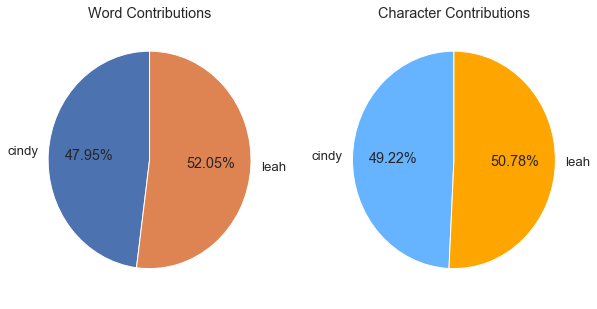

leah     19528
cindy    17539
Name: sender, dtype: int64


In [43]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.subplot(1, 2, 1)
plt.pie(senderSums.word_ct, labels=senderSums.index, startangle=90, 
       autopct='%1.2f%%')
plt.title("Word Contributions")

plt.subplot(1, 2, 2)
plt.pie(senderSums.character_ct, labels=senderSums.index, startangle=90, 
       autopct='%1.2f%%', colors = ["#66b3ff", "orange", "teal"])
plt.title("Character Contributions")

plt.show()
print(df.sender.value_counts())

Despite sending less, I tend to send slightly longer messages than Leah

In [45]:
plt.rcParams['figure.figsize'] = (6, 6)

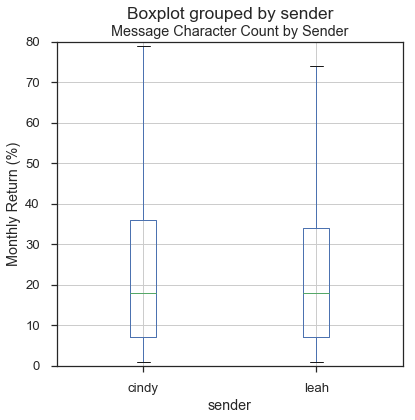

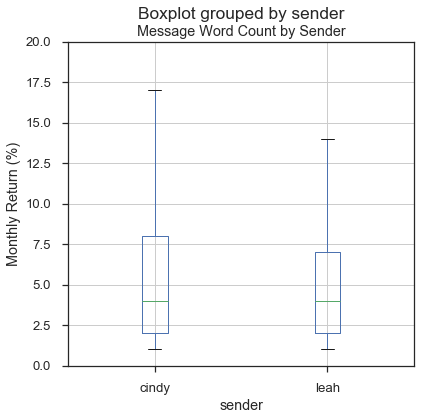

In [50]:
df.boxplot(column = 'character_ct', by = 'sender');
plt.ylim(0, 80);
plt.xticks();
plt.title("Message Character Count by Sender");
plt.ylabel("Monthly Return (%)");

df.boxplot(column = 'word_ct', by = 'sender');
plt.ylim(0, 20);
plt.xticks();
plt.title("Message Word Count by Sender");
plt.ylabel("Monthly Return (%)");

In [53]:
group_sender.describe().drop(columns=['is_from_me'])

character_ct                                                      \
              count       mean        std  min  25%   50%   75%     max   
sender                                                                    
cindy       17539.0  28.241918  45.711868  1.0  7.0  18.0  36.0  2468.0   
leah        19527.0  26.167768  39.026348  1.0  7.0  18.0  34.0  1575.0   

        word_ct                                                 
          count      mean       std  min  25%  50%  75%    max  
sender                                                          
cindy   17539.0  5.815554  7.743516  1.0  2.0  4.0  8.0  457.0  
leah    19528.0  5.670934  6.890653  1.0  2.0  4.0  7.0  305.0

Cindy's average character count (28.24) and word count (5.8) are slightly higher than Leah's 26.17 and 5.67, respectively.

Next, I'm creating a dataframe that lists every single unique word used in our chat, their frequencies, and the number of characters.

In [54]:
ct = Counter(" ".join(df["text_edited"]).split())
ct_df = pd.DataFrame(list(ct.items()),columns = ['word','freq'])
ct_df = ct_df.sort_values(by='freq', ascending=0).reset_index().drop(['index'], axis=1)
ct_df['chars'] = ct_df['word'].str.len()
ct_df.head()

,word,freq,chars
0,i,9626,1
1,the,4619,3
2,to,3885,2
3,it,3571,2
4,and,3436,3


Unsurprisingly, the top 5 most frequently used words are "i", "the", "to", "it", and "and".

In [59]:
(ct_df["chars"] * ct_df["freq"]).sum() / ct_df["freq"].sum()

3.7487762367425645

The average  length of each word is 3.75. Compared to the average word length found in documents of 4.79, the lengths of the words used in our messages are notably smaller, likely due to the more casual nature of texting and the use of abbreviations.

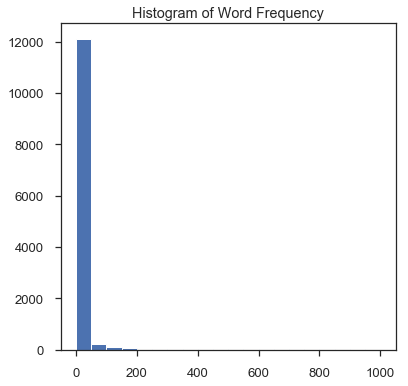

In [60]:
plt.hist(ct_df['freq'], 20, range = (0,1000));
plt.title('Histogram of Word Frequency');

In [61]:
ct_df.describe()

,freq,chars
count,12661.000000,12661.000000
mean,17.038781,6.908775
std,148.518652,4.443072
min,1.000000,1.000000
25%,1.000000,5.000000
50%,2.000000,6.000000
75%,4.000000,8.000000
max,9626.000000,117.000000


The average length of distinct words (i.e., counting each word once no matter the frequency used) is 6.91.

The mean number of times a word is used is 17.04; however, the median frequency is only 2. This makes sense as very commonly used words (frequency >100), despite making up a small portion of the 12,661 different words used (as evidenced by the histogram), will strongly skew the mean.

In order to examine the words that are more unique to our chat in particular, I created a new dataframe of words, this time dropping one character words and "stop words," an established set of words common in language.

In [62]:
# list of stop words
stops = set(stopwords.words('english'))
print(stops)

{'hadn', 'had', 'all', "haven't", 'this', 'not', 'in', 'be', 'theirs', 'so', 'once', 'did', 'such', 'when', 'about', "you're", 's', 'didn', 'does', 're', 'those', 'weren', 'with', 'whom', 'i', "weren't", "won't", 'don', 'me', 'that', 'shouldn', 'you', 'where', 'll', 'as', "hasn't", 'his', 'at', "aren't", "needn't", 'into', 'its', 'if', 'being', 'ours', 'd', 'your', 'is', 'were', 'there', 'should', "isn't", 'here', 'have', 'nor', 'same', 'some', 'which', 'needn', 'their', 'only', "you'll", 'for', 'to', "you'd", 'mightn', 'o', 'has', 'up', 'these', 'or', 'over', 'will', 'hasn', 'before', 'themselves', 'few', 'are', 'until', 'm', 'who', 'isn', 'any', 'ain', 't', 'aren', 'him', 'below', 'yourself', 'other', 'her', 'having', 'now', 'can', 'ma', 'won', 'during', 'yourselves', "it's", 'just', 'more', 'than', 'herself', 'they', "doesn't", "that'll", 'against', 'doesn', 'he', 'through', "hadn't", 'again', 'under', 'of', 'mustn', 'shan', 'but', 'very', 'because', 'doing', 'we', 'down', 'out', "s

In [63]:
ctRef_df = ct_df

In [64]:
# dropping one character words
indexNames = ctRef_df[(ctRef_df['chars'] <= 1)].index
ctRef_df.drop(indexNames, inplace=True)

In [65]:
ctRef_df.reset_index(drop=True).head()

,word,freq,chars
0,the,4619,3
1,to,3885,2
2,it,3571,2
3,and,3436,3
4,that,2671,4


In [66]:
# removing stop words
ctRef_df=ctRef_df[~ctRef_df['word'].isin(stops)]
ctRef_df = ctRef_df.reset_index(drop=True)
ctRef_df.head()

,word,freq,chars
0,like,2479,4
1,ok,1371,2
2,oh,1081,2
3,im,1056,2
4,think,948,5


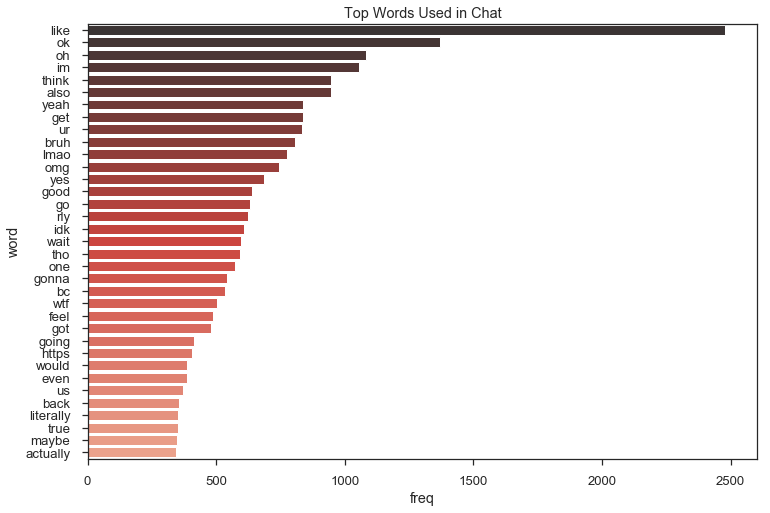

In [69]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

ax = sns.barplot(x="freq", y="word", data=ctRef_df[:35],
                 palette="Reds_d")
plt.title("Top Words Used in Chat");

In [71]:
dat = df.sort_values('date').set_index('date')

In [72]:
# resample the data for days and count the instances per day
days_resample = dat.text.resample('D').count()
data2 = pd.DataFrame({'Num': days_resample.values})

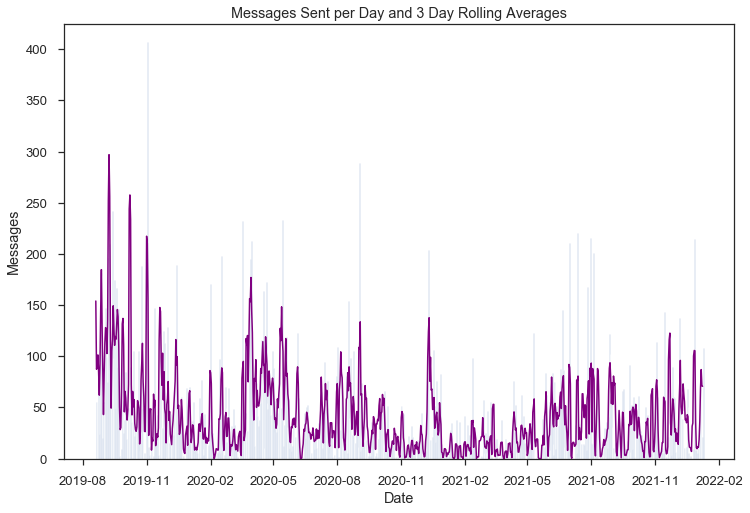

In [92]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

# line shows 3 day rolling average number of messages
plt.plot(days_resample.index, data2.Num.rolling(3, center=True).mean(), color = 'purple')
plt.bar(days_resample.index, days_resample.values, alpha=.5)
ax.set_xticks(days_resample.index);
ax.set_xticklabels(days_resample.index);
plt.xlabel("Date")
plt.ylabel("Messages")
plt.title("Messages Sent per Day and 3 Day Rolling Averages")
plt.ylim((0,425))
plt.show()

In [136]:
days_resample.mean()

42.36228571428571

In [135]:
days_resample[days_resample == days_resample.max()]

date
2019-10-08    575
Freq: D, Name: text, dtype: int64

# 

In [140]:
# mask1 = (df['date'] >= '2019-10-08') & (df['date'] < '2019-10-09')
# df[mask1].text.sample(100)

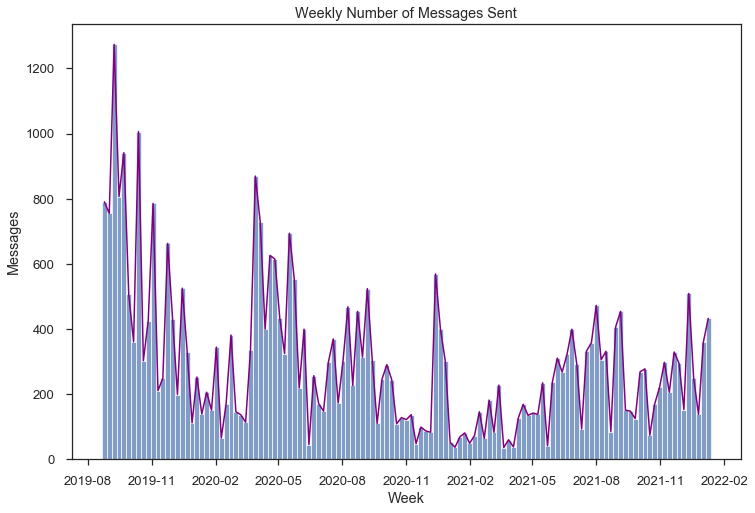

In [115]:
dat = df.sort_values('date').set_index('date')
# resample the data for weeks and count the instances per week
week_groups_resample = dat.text.resample('W').count();
plt.plot(week_groups_resample, color = 'purple')
plt.bar(week_groups_resample.index, week_groups_resample.values, alpha=.7, width=7)
ax.set_xticks(week_groups_resample.index);
ax.set_xticklabels(week_groups_resample.index);
plt.xlabel("Week")
plt.ylabel("Messages")
plt.title("Weekly Number of Messages Sent")
plt.show()

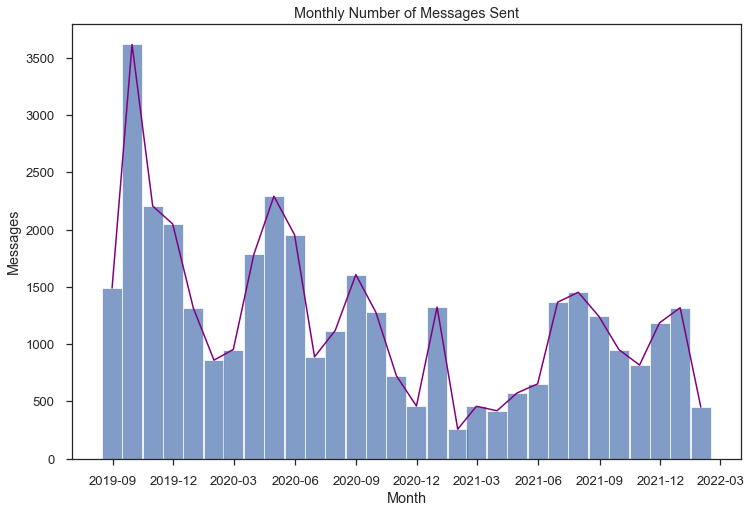

In [107]:
week_groups_resample = dat.text.resample('M').count();
plt.plot(week_groups_resample, color = 'purple')
plt.bar(week_groups_resample.index, week_groups_resample.values, alpha=.7, width=30)
ax.set_xticks(week_groups_resample.index);
ax.set_xticklabels(week_groups_resample.index);
plt.xlabel("Month")
plt.ylabel("Messages")
plt.title("Monthly Number of Messages Sent")
plt.show()

In [109]:
dfTime = df
dfTime['hour'] = pd.DatetimeIndex(dfTime['date']).hour

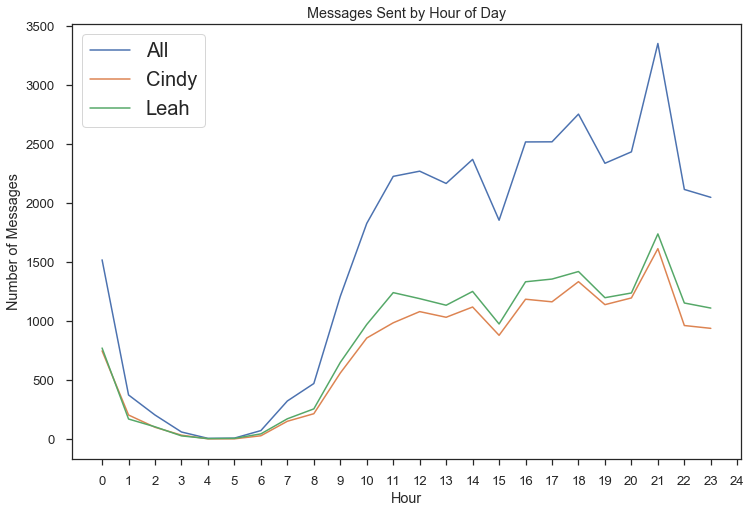

In [112]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

timeGroup = dfTime.groupby(['hour']).count().reset_index()
timeGroup
plt.plot(timeGroup.hour, timeGroup.text);

timeGroupInd = dfTime.groupby(['sender','hour']).count().reset_index()
for send in timeGroupInd.sender.unique():
    plt.plot(timeGroupInd[timeGroupInd['sender'] == send].hour, timeGroupInd[timeGroupInd['sender'] == send].text);

#print(timeGroupInd.sender.unique())
plt.legend(['All', 'Cindy', 'Leah'], prop={'size': 20});
plt.xticks(np.arange(0, 25, 1));
#plt.xticklabels(size=1)
plt.xlabel('Hour')
plt.ylabel('Number of Messages');
plt.title('Messages Sent by Hour of Day');


Our messaging tends to peak at 9PM.